In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
sys.path.append("../")
import data_loading as dl

from microfit.run_plotter import RunHistPlotter
from microfit.histogram import Binning, MultiChannelBinning, RunHistGenerator, MultiChannelHistogram

In [3]:
# RUN = ["4b", "4c", "4d"]  # this can be a list of several runs, i.e. [1,2,3]
RUN = ["3_crt", "4b", "4c", "4d", "5"]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",  # which data to load
    # truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
    # Which truth-filtered MC sets to load in addition to the main MC set. At least nu_e and dirt
    # are highly recommended because the statistics at the final level of the selection are very low.
    truth_filtered_sets=["nue", "drt"],
    # Choose which additional variables to load. Which ones are required may depend on the selection
    # you wish to apply.
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_crt_vars=True,
    # Load the nu_e set one more time with the LEE weights applied
    load_lee=False,
    # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
    # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
    enable_cache=True,
    # Since this is Open Data, we are allowed to unblind the data. By default, the data is blinded.
    blinded=False,
)

Loading run 3_crt
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5


In [13]:
# binning_def = ("reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]")
binning_def = ("reco_e", 14, (0.01, 1.55), "Reconstructed neutrino energy (GeV)")  # reproduce technote

binning_zp = Binning.from_config(*binning_def)
binning_zp.set_selection(preselection="ZP", selection="None")
binning_zp.label = "ZP"

binning_zp_crt = binning_zp.copy()
assert binning_zp_crt.selection_query is not None
binning_zp_crt.selection_query += ' and (crtveto != 1 or crthitpe < 100) and _closestNuCosmicDist > 5.'
binning_zp_crt.label = "ZP_CRT"

binning = MultiChannelBinning([binning_zp, binning_zp_crt])


In [14]:
binning_zp

Binning(variable='reco_e', bin_edges=array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  , 1.11,
       1.22, 1.33, 1.44, 1.55]), label='ZP', variable_tex='Reconstructed neutrino energy (GeV)', variable_tex_short=None, is_log=False, selection_query='nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained == 0', selection_key='None', preselection_key='ZP', selection_tex='NoCuts', selection_tex_short='NoCuts')

In [15]:
hist_gen = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
)

In [16]:
ext_hist = hist_gen.get_data_hist(type="ext")
assert ext_hist is not None
assert isinstance(ext_hist, MultiChannelHistogram)
print(f"Number of cosmics without CRT: {ext_hist['ZP'].sum()}")
print(f"Number of cosmics with CRT: {ext_hist['ZP_CRT'].sum()}")
print(f"Cosmics survival rate: {ext_hist['ZP_CRT'].sum() / ext_hist['ZP'].sum()}")
print(f"Cosmics rejection rage: {1 - ext_hist['ZP_CRT'].sum() / ext_hist['ZP'].sum()}")

Number of cosmics without CRT: 2914.342563011588
Number of cosmics with CRT: 1167.068159785433
Cosmics survival rate: 0.4004567529561186
Cosmics rejection rage: 0.5995432470438814


In [17]:
mc_hists = hist_gen.get_mc_hists(category_column="paper_category")
nue_cc_hist = mc_hists[11]
assert isinstance(nue_cc_hist, MultiChannelHistogram)
print(f"Number of nue CC: {nue_cc_hist['ZP'].sum()}")
print(f"Number of nue CC with CRT: {nue_cc_hist['ZP_CRT'].sum()}")
print(f"nue CC survival rate: {nue_cc_hist['ZP_CRT'].sum() / nue_cc_hist['ZP'].sum()}")
print(f"nue CC rejection rage: {1 - nue_cc_hist['ZP_CRT'].sum() / nue_cc_hist['ZP'].sum()}")

Number of nue CC: 93.3109290603715
Number of nue CC with CRT: 90.33537819919873
nue CC survival rate: 0.9681114432024611
nue CC rejection rage: 0.03188855679753888


../microfit/run_plotter.py:126: UserWarning: No signal category found in the MC hists. Not separating signal.
  warnings.warn("No signal category found in the MC hists. Not separating signal.")


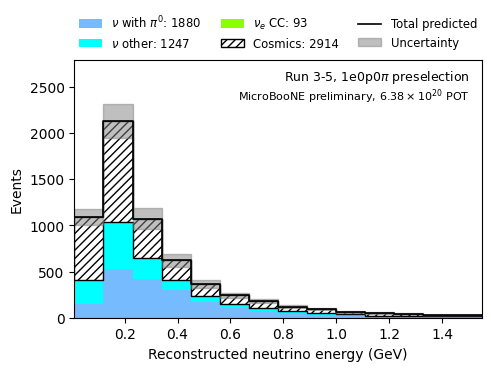

In [18]:
import matplotlib.pyplot as plt

ax, _ = RunHistPlotter(hist_gen).plot(
    category_column="paper_category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    run_title="Run 3-5",
    show_data=False,
    title="1e0p0$\\pi$ preselection",
    sums_in_legend=True,
    figsize=(4.8, 3.6),
    channel="ZP",
    # extra_text=f"Number of cosmics: {ext_hist['ZP'].sum():.0f}",
)
plt.savefig("paper_histograms/zp_presel_without_crt_r345.pdf", bbox_inches="tight")

../microfit/run_plotter.py:126: UserWarning: No signal category found in the MC hists. Not separating signal.
  warnings.warn("No signal category found in the MC hists. Not separating signal.")


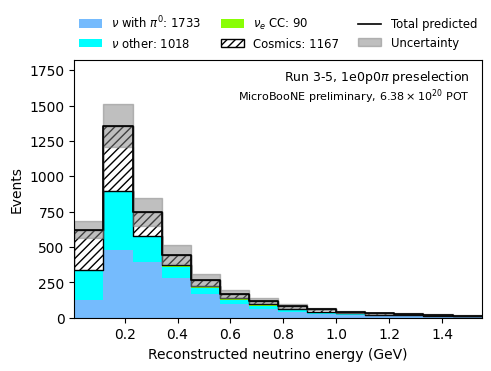

In [19]:
ax, _ = RunHistPlotter(hist_gen).plot(
    category_column="paper_category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    run_title="Run 3-5",
    show_data=False,
    title="1e0p0$\\pi$ preselection",
    sums_in_legend=True,
    figsize=(4.8, 3.6),
    channel="ZP_CRT",
    # extra_text=f"Number of cosmics: {ext_hist['ZP_CRT'].sum():.0f}",
)
plt.savefig("paper_histograms/zp_presel_with_crt_r345.pdf", bbox_inches="tight")